# 1. Brief description of the problem and data

The rapid advancements in artificial intelligence and machine learning have led to significant progress in various domains. Now, we have a chance to utilize AI to tackle the problem of identifying metastatic cancer in small image patches taken from larger digital pathology scans. A Convolutional Neural Network (CNN) is better to solve this kind of a binary image classification problem, where the goal is to determine whether a given image patch contains metastatic cancer or not. 

The data for this challenge is based on the PatchCamelyon (PCam) benchmark dataset, which has been modified to remove duplicate images. PCam dataset is interesting due to its size, simplicity, and approachability. It allows for models to be trained on a single GPU within a few hours and achieve competitive scores. As for the Natural Language Processing (NLP) task, it involves the processing, understanding, and generation of human language by computer algorithms. NLP techniques are widely used for tasks such as sentiment analysis, machine translation, and chatbot development.

# 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

**2.1 Load data and list the images**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random
from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift + Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**2.2 Label files Exploration**

Sample Submission DataFrame:
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

Train Labels DataFrame:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Missing values:
 id       0
label    0
dtype: int64


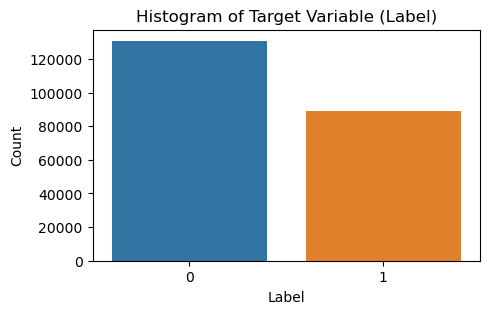

In [2]:
import pandas as pd

# Set the paths to the CSV files
sample_submission_path = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'
train_labels_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

# Read the CSV files
sample_submission_df = pd.read_csv(sample_submission_path)
train_labels_df = pd.read_csv(train_labels_path)

# Display the first few rows of each DataFrame
print("Sample Submission DataFrame:")
print(sample_submission_df.head())

print("\nTrain Labels DataFrame:")
print(train_labels_df.head())

# Data cleaning: Check for missing values
missing_values = train_labels_df.isnull().sum()
print("Missing values:\n", missing_values)

# Visualize the distribution of the target variable (label)
plt.figure(figsize=(5, 3))
sns.countplot(x='label', data=train_labels_df)
plt.title('Histogram of Target Variable (Label)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

**2.3 Visualize the pictures**

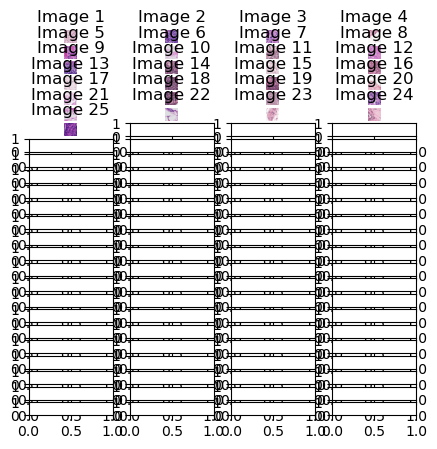

In [3]:
# Set the path to the images
train_images_path = '/kaggle/input/histopathologic-cancer-detection/train/'

# Get a list of image file names
image_files = os.listdir(train_images_path)

# Randomly select a few images
num_images_to_show = 25
selected_images = random.sample(image_files, num_images_to_show)

# Plot the selected images in a grid
fig, axes = plt.subplots(25, 4, figsize=(5, 5))
axes = axes.ravel()

for i, img_name in enumerate(selected_images):
    img_path = os.path.join(train_images_path, img_name)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")

plt.show()

# 3.Model to choose

For the problem of histopathologic cancer detection, we can start with a Convolutional Neural Network (CNN) as it is well-suited for image classification tasks. Below, I will describe a possible model architecture and the reasoning behind the choices made.

* Input Layer: The input layer will accept images of shape (96, 96, 3) for the PCam dataset (96x96 pixels with 3 color channels).

* Convolutional Layer 1: Apply 32 filters of size (3, 3) with a ReLU activation function. This layer will help the model learn basic features such as edges and textures.

* Max Pooling Layer 1: Apply max pooling with a pool size of (2, 2) to reduce the spatial dimensions of the input and retain important features.

* Convolutional Layer 2: Apply 64 filters of size (3, 3) with a ReLU activation function. This layer will learn more complex features from the input.

* Max Pooling Layer 2: Apply max pooling with a pool size of (2, 2).

* Convolutional Layer 3: Apply 128 filters of size (3, 3) with a ReLU activation function.

* Max Pooling Layer 3: Apply max pooling with a pool size of (2, 2).

* Flatten Layer: Flatten the output from the previous layer into a 1D array.

* Fully Connected Layer 1: Create a dense layer with 256 neurons and a ReLU activation function. This layer will learn to combine features from the previous layers to make predictions.

* Dropout Layer: Apply dropout with a rate of 0.5 to prevent overfitting.

* Output Layer: Create a dense layer with 1 neuron and a sigmoid activation function to produce a probability of cancer presence.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import torch.nn.functional as F

class CancerNet(nn.Module):
    def __init__(self):
        super(CancerNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  # Update the input size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        
        #x = x.view(-1, 64 * 12 * 12)  # Update the view size
        x = torch.flatten(x, start_dim=1)  # Replace view() with flatten()
            
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

    
# Create the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CancerNet().to(device)

# Print the structure of the model
print(model)

CancerNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


# 4. Results and Analysis

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.
Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

**4.1 Split the datasets**

In [25]:
# Plan of analysis:
# 1. Split the data into training and validation sets
# 2. Preprocess the image data (resize, normalize, etc.)
# 3. Build a CNN model for classification
# 4. Train the model on the training data and evaluate its performance on the validation data
# 5. Fine-tune the model (if necessary) and make predictions on the test data

import os
import pandas as pd
import numpy as np
from skimage.io import imread

**4.2 Preprocess the image data (resize, normalize, etc.)**

In [5]:
from skimage.io import imread
from skimage.transform import resize
from skimage.io import imread

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Load the first image using the file name and path
first_image = imread(os.path.join(train_images_path, image_files[0]))

# Get the dimensions of the image
height, width, channels = first_image.shape

print(f"Image width: {width}")
print(f"Image height: {height}")
print(f"Image dimensions: {width} x {height} x {channels}")

# Load train labels
train_labels_df = pd.read_csv(train_labels_path)

# Select 0.01% of the data
selected_data = train_labels_df.sample(frac=0.01, random_state=42)

# Split the selected dataset into training and validation sets (1/10 for training)
train_df, val_df = train_test_split(selected_data, train_size=0.6, random_state=42)


print(f"Number of images in train_labels_df: {train_labels_df.shape[0]}")
print(f"Number of images in selected_data: {selected_data.shape[0]}")
print(f"Number of images in train_df: {train_df.shape[0]}")
print(f"Number of images in val_df: {val_df.shape[0]}")


# Create a custom dataset class
class CancerDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0]) + '.tif'
        image = imread(img_name)
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

# Create datasets and data loaders
train_dataset = CancerDataset(train_df, train_images_path, transform=data_transform)
val_dataset = CancerDataset(val_df, train_images_path, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Image width: 96
Image height: 96
Image dimensions: 96 x 96 x 3
Number of images in train_labels_df: 220025
Number of images in selected_data: 2200
Number of images in train_df: 1320
Number of images in val_df: 880


**4.3 Build and evaluate our model**

In [6]:
import tqdm
    
# Create the model (assuming you have the model definition from previous steps)
model = CancerNet()

# Compile the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Train the model
num_epochs = 20
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    model.train()
    for images, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1} (Training)"):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1} (Validation)"):
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")


# Save the trained model
#model_path = "/kaggle/working/model.pth"
#torch.save(model.state_dict(), model_path)

Epoch 1 (Validation): 100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Epoch 1, Train Loss: 0.6976183141980853, Val Loss: 0.6931471824645996


Epoch 2 (Validation): 100%|██████████| 28/28 [00:03<00:00,  8.15it/s]


Epoch 2, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 3 (Validation): 100%|██████████| 28/28 [00:04<00:00,  6.87it/s]


Epoch 3, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 4 (Validation): 100%|██████████| 28/28 [00:03<00:00,  7.76it/s]


Epoch 4, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 5 (Validation): 100%|██████████| 28/28 [00:03<00:00,  9.08it/s]


Epoch 5, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 6 (Validation): 100%|██████████| 28/28 [00:03<00:00,  8.95it/s]


Epoch 6, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 7 (Validation): 100%|██████████| 28/28 [00:03<00:00,  9.03it/s]


Epoch 7, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 8 (Validation): 100%|██████████| 28/28 [00:03<00:00,  8.16it/s]


Epoch 8, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 9 (Validation): 100%|██████████| 28/28 [00:03<00:00,  8.65it/s]


Epoch 9, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 10 (Validation): 100%|██████████| 28/28 [00:03<00:00,  9.01it/s]


Epoch 10, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 11 (Validation): 100%|██████████| 28/28 [00:03<00:00,  9.09it/s]


Epoch 11, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 12 (Validation): 100%|██████████| 28/28 [00:03<00:00,  9.11it/s]


Epoch 12, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 13 (Validation): 100%|██████████| 28/28 [00:03<00:00,  9.11it/s]


Epoch 13, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 14 (Validation): 100%|██████████| 28/28 [00:03<00:00,  8.87it/s]


Epoch 14, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 15 (Validation): 100%|██████████| 28/28 [00:03<00:00,  8.61it/s]


Epoch 15, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 16 (Validation): 100%|██████████| 28/28 [00:03<00:00,  9.01it/s]


Epoch 16, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 17 (Validation): 100%|██████████| 28/28 [00:03<00:00,  9.12it/s]


Epoch 17, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 18 (Validation): 100%|██████████| 28/28 [00:03<00:00,  8.90it/s]


Epoch 18, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 19 (Validation): 100%|██████████| 28/28 [00:03<00:00,  8.63it/s]


Epoch 19, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


Epoch 20 (Validation): 100%|██████████| 28/28 [00:03<00:00,  9.02it/s]

Epoch 20, Train Loss: 0.6931471824645996, Val Loss: 0.6931471824645996


**4.4 Fine-tune the model**

(if necessary) and make predictions on the test data

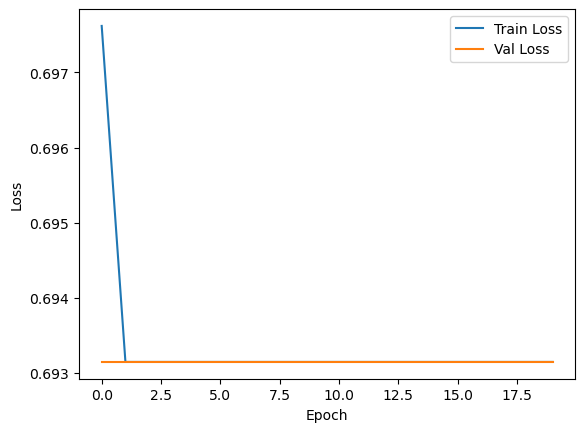

In [7]:
# Plot the loss history
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**4.5 Make predictions and save the result**

In [ ]:
import numpy as np
import os
import torch
import pandas as pd
from skimage.io import imread

# Set the model to evaluation mode
model.eval()

# Load test images
test_images_path = '/kaggle/input/histopathologic-cancer-detection/test/'
test_image_files = os.listdir(test_images_path)

# Process test images in smaller batches
batch_size = 128
num_images = len(test_image_files)
predictions = []

for i in range(0, num_images, batch_size):
    batch_files = test_image_files[i:i + batch_size]
    batch_images = [imread(os.path.join(test_images_path, img_file)) for img_file in batch_files]
    batch_images_normalized = np.array(batch_images) / 255.0
    batch_images_tensor = torch.tensor(batch_images_normalized, dtype=torch.float32).permute(0, 3, 1, 2)
    
    with torch.no_grad():
        model.eval()
        batch_predictions = model(batch_images_tensor).numpy()
        predictions.extend(batch_predictions)

predictions = np.array(predictions)

# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5).astype(int).flatten()

# Print the predictions for the first 10 images
for i in range(10):
    print(f"Image {i + 1}: {test_image_files[i]}")
    print(f"Probability: {predictions[i][0]:.4f}")
    print(f"Predicted Label: {binary_predictions[i]}\n")

# Create a DataFrame with the image IDs and the predictions
submission_df = pd.DataFrame({'id': [img_file[:-4] for img_file in test_image_files], 'label': binary_predictions})

# Print the length of the submission DataFrame
print(f"Total number of predictions: {len(submission_df)}")

# Remove the old submission.csv file if it exists
submission_csv_path = '/kaggle/working/submission.csv'
if os.path.exists(submission_csv_path):
    os.remove(submission_csv_path)

# Save the predictions to a new CSV file
submission_df.to_csv(submission_csv_path, index=False)


In [ ]:
import numpy as np
import os
import torch
import pandas as pd
from skimage.io import imread

# Load the trained model
#model_path = "/kaggle/working/model.pth"
#model = CancerNet()  # Initialize the CancerNet model from your model module
#model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Load test images
test_images_path = '/kaggle/input/histopathologic-cancer-detection/test/'
test_image_files = os.listdir(test_images_path)

# Load test images and normalize them

#test_images = [imread(os.path.join(test_images_path, img_file)) for img_file in test_image_files[:10]]
test_images = [imread(os.path.join(test_images_path, img_file)) for img_file in test_image_files]
test_images_normalized = np.array(test_images) / 255.0

# Convert test_images_normalized to PyTorch tensor
test_images_tensor = torch.tensor(test_images_normalized, dtype=torch.float32).permute(0, 3, 1, 2)

# Make predictions on the first 10 test images
with torch.no_grad():
    model.eval()
    predictions_10 = model(test_images_tensor).numpy()

# Convert probabilities to binary predictions
binary_predictions_10 = (predictions_10 > 0.5).astype(int).flatten()

# Print the predictions
for i in range(10):
    print(f"Image {i + 1}: {test_image_files[i]}")
    print(f"Probability: {predictions_10[i][0]:.4f}")
    print(f"Predicted Label: {binary_predictions_10[i]}\n")

# Create a DataFrame with the image IDs and the predictions
submission_df = pd.DataFrame({'id': [img_file[:-4] for img_file in test_image_files[:10]], 'label': binary_predictions_10})

# Save the predictions to a CSV file
submission_df.to_csv('/kaggle/working/submission.csv', index=False)


In [38]:
import os
import shutil

# Remove model.pth
model_path = "/kaggle/working/model.pth"
if os.path.isfile(model_path):
    os.remove(model_path)
    print(f"Removed {model_path}")
else:
    print(f"{model_path} not found")

# Remove working_directory.zip
zip_path = "/kaggle/working/working_directory.zip"
if os.path.isfile(zip_path):
    os.remove(zip_path)
    print(f"Removed {zip_path}")
else:
    print(f"{zip_path} not found")

    
working_directory = '/kaggle/working/'
list_of_files = os.listdir(working_directory)

print("Contents of /kaggle/working/ directory:")
for file in list_of_files:
    print(file)

#shutil.make_archive('/kaggle/working/working_directory', 'zip', '/kaggle/working/')

Removed /kaggle/working/model.pth
Removed /kaggle/working/working_directory.zip
Contents of /kaggle/working/ directory:
.virtual_documents
submission.csv
__notebook_source__.ipynb


# 5. Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

# 6. Produce Deliverables

High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard 
These deliverables serve two purposes- grade for this course and your project portfolio that you can show when you apply for jobs.
